In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('../')

In [2]:
import os
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.metrics import mean_squared_error

from covid19_pytoolbox.settings import BASE_DATA_PATH, BASE_IMAGES_PATH
from covid19_pytoolbox import plotting
from covid19_pytoolbox.italy.data import ISS
from covid19_pytoolbox.italy.data import DPC
from covid19_pytoolbox.smoothing.seasonalRSVD.LogRSVD import LogSeasonalRegularizer
from covid19_pytoolbox.smoothing.tikhonovreg import TikhonovRegularization
from covid19_pytoolbox.modeling import Rt
from covid19_pytoolbox.utils import smape, padnan

## Rt gamma parameters:

In [3]:
alpha = 1.87
beta = 0.28

ALPHA=100.

## Load DPC data, smooth them and compute naive Rt

In [4]:
DPC_data = DPC.load_daily_cases_from_github()
TIMESTEPS, FIRST_CASI_SOSP_DIAGNOSTICO = DPC.preprocess(DPC_data)
DPC.compute_first_diffs(DPC_data)
regularizer = TikhonovRegularization(timesteps=TIMESTEPS, alpha=ALPHA)
DPC.tikhonov_smooth_differentiate(DPC_data, regularizer)
DPC.bulk_compute_naive_Rt(DPC_data, alpha=alpha, beta = beta)

{   'deceduti_giornalieri': 'deceduti',
    'dimessi_guariti_giornalieri': 'dimessi_guariti',
    'nuovi_casi_da_screening': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico': 'casi_da_sospetto_diagnostico',
    'tamponi_giornalieri': 'tamponi'}
{   'deceduti_giornalieri_smoothed': 'deceduti',
    'dimessi_guariti_giornalieri_smoothed': 'dimessi_guariti',
    'nuovi_casi_da_screening_smoothed': 'casi_da_screening',
    'nuovi_casi_da_sospetto_diagnostico_smoothed': 'casi_da_sospetto_diagnostico',
    'nuovi_positivi_smoothed': 'totale_casi',
    'tamponi_giornalieri_smoothed': 'tamponi'}
tamponi_giornalieri_smoothed - TIC R2: 0.9999942372177546
dimessi_guariti_giornalieri_smoothed - TIC R2: 0.9999877362972297
deceduti_giornalieri_smoothed - TIC R2: 0.999994311530703
nuovi_positivi_smoothed - TIC R2: 0.9999951068771902
nuovi_casi_da_sospetto_diagnostico_smoothed - TIC R2: 0.9677554781475112
nuovi_casi_da_screening_smoothed - TIC R2: 0.9620845194410493
[   'nuovi_positivi',
 

# Use RSVD: Regularized Singular Value Decomposition

RSVD allows to detect the seasonal component of the signal.

In the case of DPC `nuovi_positivi` we have a **weekly seasonality**, hence `season_period = 7`

RSVD has been proposed by Wei Lin, Jianhua Huang (Texas A&M University), Tucker Mcelroy (U.S. Census Bureau), in this [paper](https://www.researchgate.net/publication/327256122_Time_Series_Seasonal_Adjustment_Using_Regularized_Singular_Value_Decomposition)

It essentially cast the signal vector into a matrix whose columns are the seasons and the rows are the repetitive periods of a complete series of seasons. In our case the matrix shape will be `(~len(signal) / 7, 7)`.
Singular Value Decomposition is applied to the matrix so that singular values represent the seasonal component of the signal. Each (7 in our case) seasonal component is regularized via Tikhonov, following the hypotheis that each season component, period after period, must change smoothly. The Tikhonov regularization paramether is fitted via "leave one out cross validation".

The advantage of this method with respect to the SARIMA approach is that **we don't need to take moving averages**, and we don't need to tune any metaparameter of the model.

We wrote the python porting of the original R code.
The python porting is available from the following namespace:
```
import covid19_pytoolbox.smoothing.seasonalRSVD
```

The following features have been added to the original work:
- RSVD is applied by means of two different classes:
  - `SeasonalRegularizer` applies RSVD to the plain data
  - `LogSeasonalRegularizer` applies RSVD on the logarithm of the data to remove exponential trends; the inverse functions are correctly applied before returning the outputs, to remove the effects of taking the logarithm on the original signal
- both classes accept a `difference_degree` parameters; if greater then 0, the `n-th = difference_degree` difference is taken on the original signal prior to apply RSVD; this is helpful to remove non-stationarity in the original data
- the `adfuller` test can be performed on the input data to check (manually) if any non-stationary component is present
- the Tikhonov regularized trend is extracted from the deseasoned signal
- residuals are computed as differenes between the deseasoned signal and the smoothed trend; relative residuals are also computed by the `LogSeasonalRegularizer`
- the signal is left truncated to obtain the RSVD matrix; before returning, the outputs are padded with `np.nan` to the left, to rebuild the original vector shape


In [5]:
DPC.RSVD_smooth_data(DPC_data, alpha=alpha, beta=beta, difference_degree=2, trend_alpha=ALPHA)

['nuovi_positivi']
nuovi_positivi_deseason
info_cri:  -2.142887978904129
info_cri:  -1.5670543893926383
TIC R2: 0.9942593076604486
patterns: 1
(   -5.844081078045291,
    3.7187352646940293e-07,
    17,
    344,
    {   '1%': -3.4495033946549123,
        '10%': -2.5712658305164955,
        '5%': -2.8699787979596136},
    -138.87718502572432)
new columns generated:
[   'nuovi_positivi_deseason',
    'nuovi_positivi_deseason_seasonality',
    'nuovi_positivi_deseason_smoothed',
    'nuovi_positivi_deseason_residuals',
    'nuovi_positivi_deseason_relative_residuals',
    'nuovi_positivi_deseason_smoothed_Rt']


## Plotting the signal after applying RSVD

- the blue line is the original signal
- the violet line represent the oscillating seasonal component
- the orange line is the deseasoned signal
  - we can see how the orange line is much less oscillating with respect to the blue one, as RSVD succeded in removing the seasonal component
- the red line represents the smoothed trend of the deseasoned signal

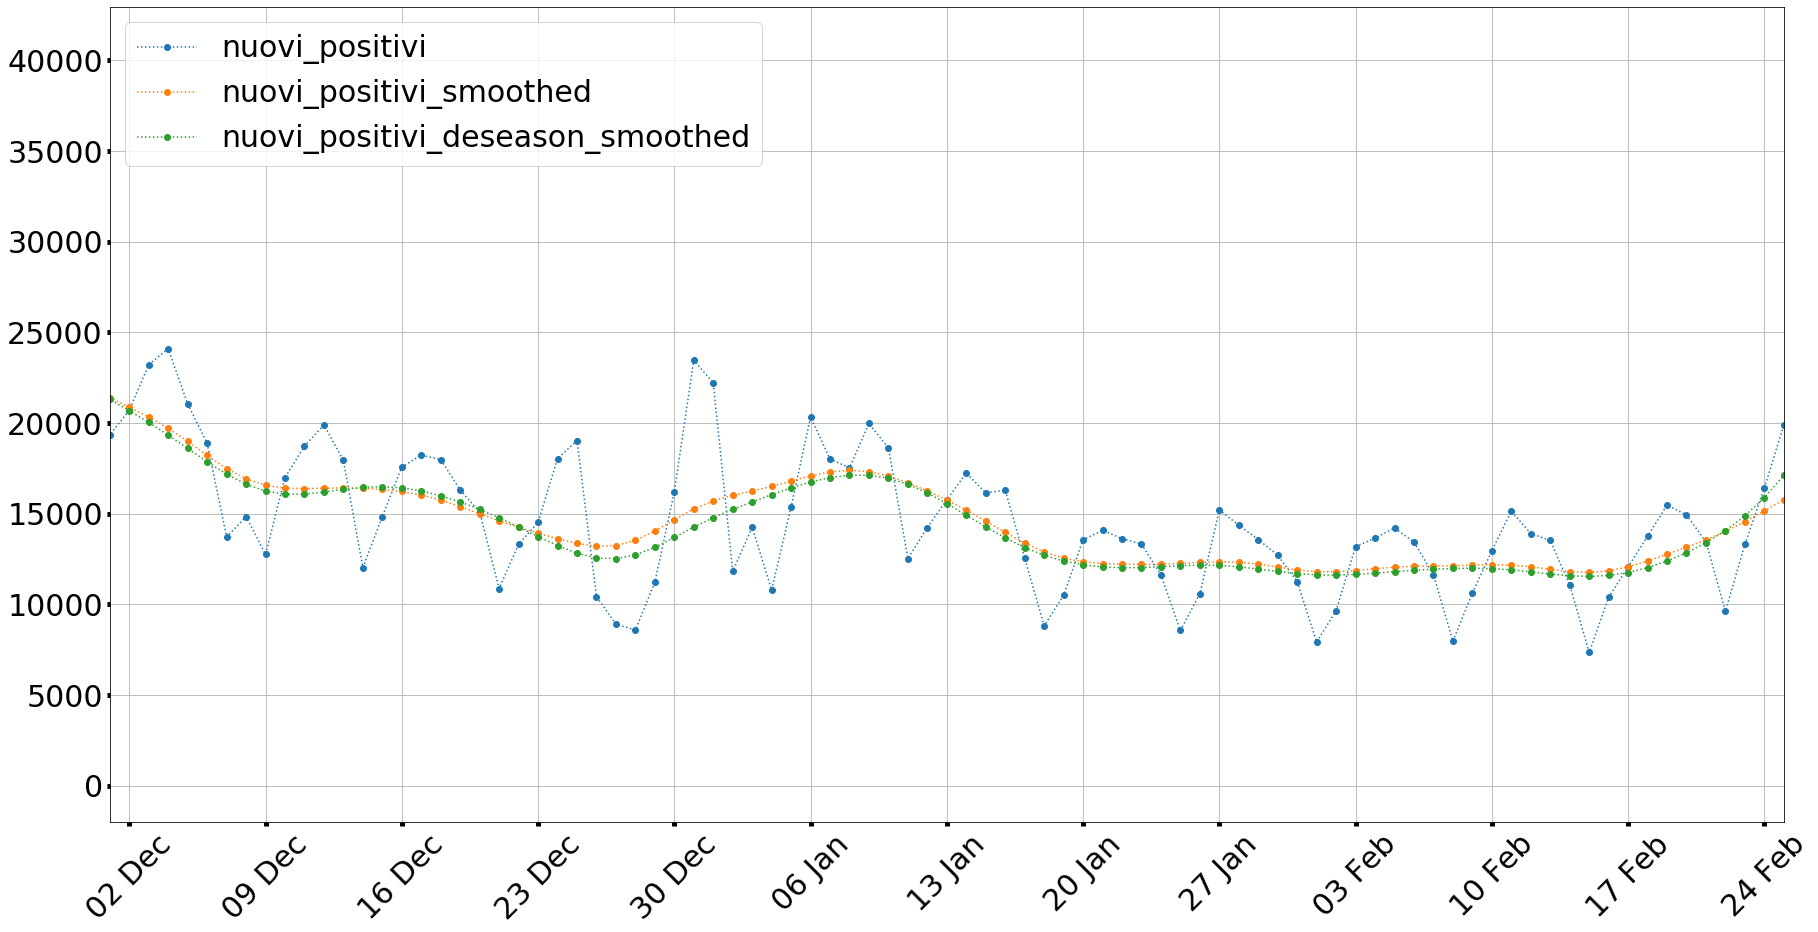

In [6]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'nuovi_positivi', 
        'nuovi_positivi_smoothed',
        'nuovi_positivi_deseason_smoothed'
    ],
    #xlim=(datetime(2020,7,25), datetime(2020,10,1)),#DPC_data.data.max()),
    #ylim=(-1000,1000),
    xlim=(datetime(2020,12,1), DPC_data.data.max()),
    #ylim=(-10000,40000),
    legend_loc="upper left"
)

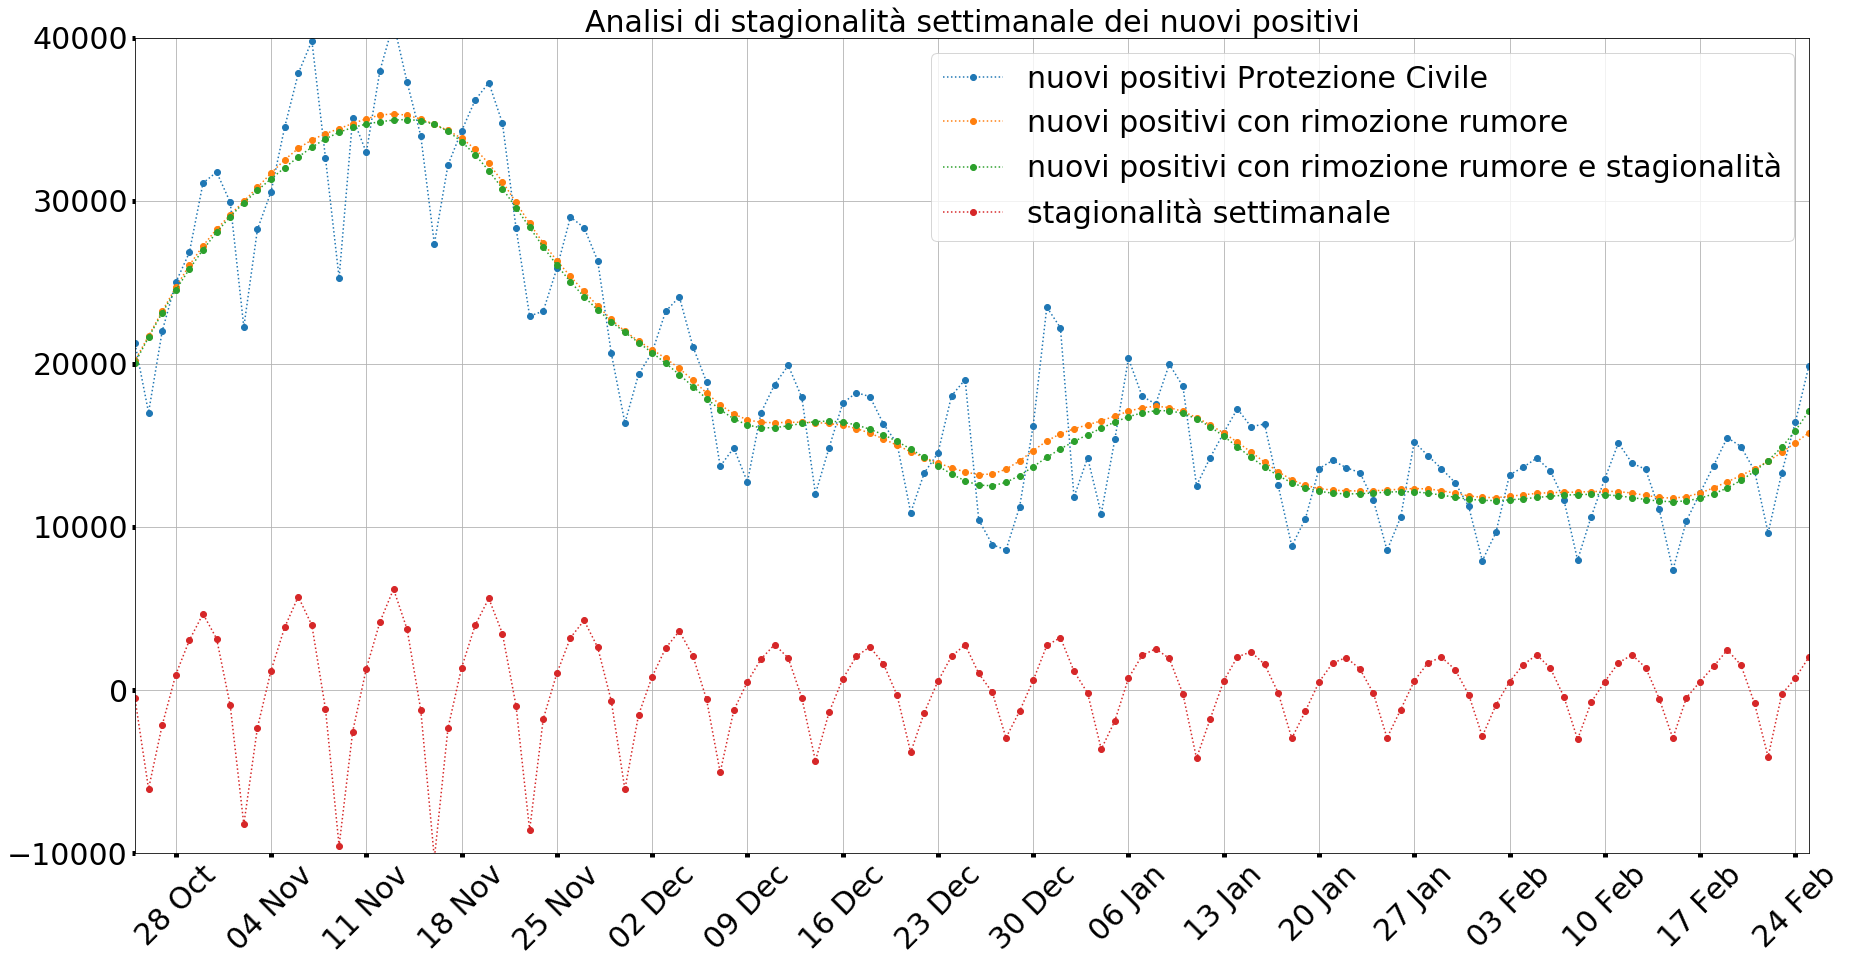

In [7]:
plotting.plot_series(
    title='Analisi di stagionalità settimanale dei nuovi positivi',
    data=[{
        'df': DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi', 
            'nuovi_positivi_smoothed',
            'nuovi_positivi_deseason_smoothed',
            'nuovi_positivi_deseason_seasonality'
        ],
        'labels': [
            'nuovi positivi Protezione Civile',
            'nuovi positivi con rimozione rumore',
            'nuovi positivi con rimozione rumore e stagionalità',
            'stagionalità settimanale'
        ]
    }],
    xlim=(datetime(2020,10,25), DPC_data.data.max()),
    ylim=(-10000,40000),
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'seasonality.{}'),
    legend_loc="upper right"
)

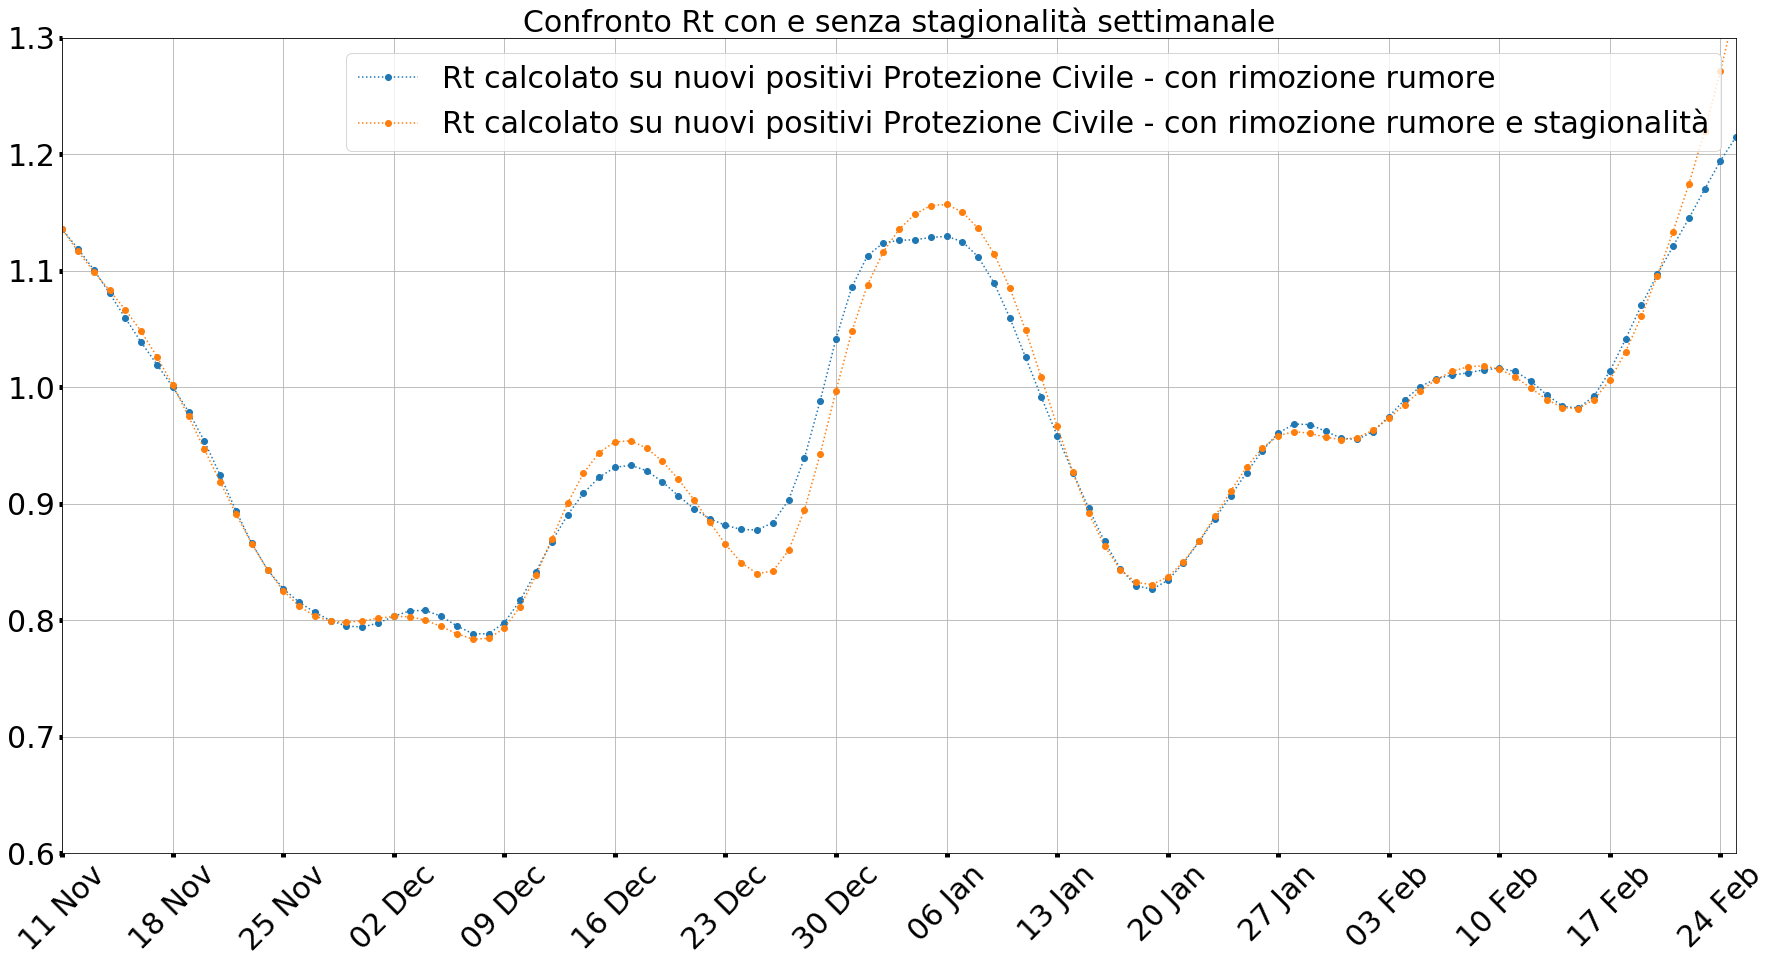

In [8]:
plotting.plot_series(
    title='Confronto Rt con e senza stagionalità settimanale',
    data=[{
        'df':DPC_data,
        'xfield': 'data',
        'yfields':[
            'nuovi_positivi_smoothed_Rt',
            'nuovi_positivi_deseason_smoothed_Rt', 
        ],
        'labels':[
            'Rt calcolato su nuovi positivi Protezione Civile - con rimozione rumore',
            'Rt calcolato su nuovi positivi Protezione Civile - con rimozione rumore e stagionalità',
        ]
    }],
    img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,'Rt_seasonality.{}'),
    xlim=(datetime(2020,11,11), DPC_data.data.max()),
    ylim=(0.6,1.3),
    legend_loc="upper right"
)

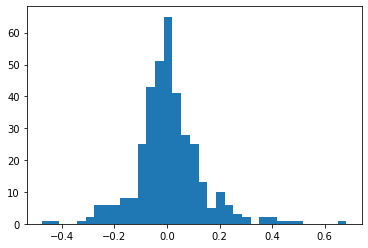

In [10]:
_=plt.hist(DPC_data.nuovi_positivi_deseason_relative_residuals,bins=35)

# Predict the next value of new cases

From the base formula for $R_t$:
$$\large{R_t = \frac{I_t}{\sum_{s=1}^t w_s I_{t-s}}}$$

we can compute the next $I_{t+1}$ value, given $R_{t+1}$:

$$\large{{I_{t+1}} = R_{t+1} \times {\sum_{s=1}^{t+1} w_s I_{t+1-s}}}$$

$$s'=s-1$$

$$\large{{I_{t+1}} = R_{t+1} {\sum_{s'=0}^{t} w_{s'+1} I_{t-s'}}}$$

Using Taylor to expand $R_{t+1}$:

$$R(t+dt) = R(t) + dR(t)dt + \frac{1}{2} d^2R(t) dt^2$$
$$R(t+\Delta t) = R(t) + \Delta R(t)\Delta t + \frac{1}{2} \Delta^2R(t) \Delta t^2$$
$$\Delta t = 1$$
$$R(t+1) = R(t) + [R(t)-R(t-1)] + \frac{1}{2} [R(t)-R(t-1)-(R(t-1)-R(t-2))]$$
$$ = 2R(t)-R(t-1) + \frac{1}{2} [R(t)-2R(t-1)+R(t-2)]$$
$$ = \frac{3}{2} R(t) - 2 R(t-1) +\frac{1}{2} R(t-2)$$

We finally have:
$$\large{{I_{t+1}} = \left[\frac{3}{2} R_t - 2 R_{t-1} +\frac{1}{2} R_{t-2} \right] {\sum_{s'=0}^{t} w_{s'+1} I_{t-s'}}}$$

In [11]:
def next_from_taylor(x):
    return 2.5*x - 2.*padnan(x[:-1],(1,0)) + 0.5*padnan(x[:-2],(2,0))
    #return 2*x - 1.*padnan(x[:-1],(1,0))

In [12]:
def predict_next_case(cases, rt, alpha, beta):
    return (
        Rt.naive.infectious_charge(np.nan_to_num(padnan(cases,(0,1)),nan=0.), alpha=alpha,beta=beta)[1:] 
        * next_from_taylor(rt)
    )

In [13]:
def pred_errors(cases, cases_pred):
    args_rt = cases.dropna()[4:], cases_pred.dropna()
    args_dummy = cases.dropna()[1:], cases[:-1].dropna()
    return{
        'pred_with_rt': {
            'smape': smape(*args_rt)*100,
            'rmse': mean_squared_error(*args_rt, squared=False)            
        },
        'pred_dummy': {
            'smape': smape(*args_dummy)*100,
            'rmse': mean_squared_error(*args_dummy, squared=False)                        
        }
    }

# Day by day computations

In [14]:
def predict_next_value(X, use_last_values=None, search_steps=100):
    if not use_last_values:
        use_last_values = X.shape[0]
        
    alphasmapes = []
    search_alpha = np.linspace(0,10.,search_steps)
    pad = 3

    smapes = []
    x = X[-use_last_values:]
    for alpha in search_alpha:
        tik = TikhonovRegularization(timesteps=len(x), alpha=alpha)
        x_tik = tik.stat_smooth_data(x, verbose=False)
        x_pred = padnan(next_from_taylor(x_tik), (1,0))
        pred_smape = smape(x[pad:],x_pred[pad:-1])*100
        smapes.append(pred_smape)

    alpha = search_alpha[np.argmin(smapes)]
    tik = TikhonovRegularization(timesteps=len(x), alpha=alpha)
    x_tik = tik.stat_smooth_data(x, verbose=False)
    x_pred = padnan(next_from_taylor(x_tik), (X.shape[0] - use_last_values + 1,0))
    return x_pred

In [15]:
def truncnorm(mu, sigma, lower, upper, size):
    tn = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    return tn.rvs(size)

# Obtain the confidence interval from the predictions

$$\large{X_t = S_t + E_t}$$

where:
- $X$ is the original signal
- $S$ is the seasonal component
- $E$ is the deseasoned component

$$\large{E_t = T_t + \epsilon_t}$$

where:
- $T$ is the smoothed trend
- $\epsilon$ is the residual

$$\large{X_{t+1}= T_{t+1} + \epsilon_{t+1} + S_{t+1}}$$

where we can approximate $X_{t+1}$ with the following:
- $T_{t+1}$ is approximated via Taylor on the previous $R_t$ knowledge
- $\epsilon_{t+1}$ is sampled from a gaussian distribution, with $\mu=0$ and $\sigma=STD(previous residuals on 7 days)$
- $S_{t+1}$ is approximated with taylor from the last $S_{t+1-period}$ known value

## Strategy:

1. deseason once and obtain $T, R, S$
2. with those sample multiple values of $X_{t+1}$
3. generate multiple possible series $X^i$ with $i$ spanning the samples
4. deseason again each of the possible series
5. drop the last value as it is tomorrow
5. compute mean and confidence interval from all the possible deseasoned series

In [16]:
alpha = 1.87
beta = 0.28

def draw_expanded_series(X, draws, season_period, trend_alpha, difference_degree, truncate, alpha, beta, res_window=None, verbose=False):

    if type(X) == pd.Series:
        X = X.to_numpy()
    
    # res_window
    if not res_window:
        res_window = season_period
    
    # deseason:
    lrsvd = LogSeasonalRegularizer(
        X, season_period=season_period, max_r=season_period, 
        trend_alpha=trend_alpha, difference_degree=difference_degree, verbose=verbose)    
    m = lrsvd.fit()
    
    # truncate means that, AFTER deseasoning, we drop the last element:
    # in this way, deseasoning is affected by the additional element in 
    # the original series, while we drop the last result as it is in the future
    if truncate:
        sl = np.s_[:-1]
    else:
        sl = np.s_[:]
    T, S, eps_rel = m.trend[sl], m.season_svd[sl], m.relative_residuals[sl]
    
    _, _, S_hat = LogSeasonalRegularizer.periods_to_matrix(S, season_period)
    #print(S_hat[-2:,:])
    
    # compute Rt on T
    rt = padnan(Rt.naive.compute_Rt(T[m.padding_left:], alpha, beta), (m.padding_left,0))
    
    # predict next T value
    T_next = predict_next_case(T, rt, alpha, beta)[-1]
    
    # predict next S value
    # we need the season of tomorrow
    # the season of today is the last column in S_hat
    # hence -> the season of tomorrow is the first column, as seasons are periodic
    S_tomorrow = S_hat[:,0]
    # predict the next value of S_tomorrow
    S_tomorrow_next = predict_next_value(S_tomorrow, use_last_values=15)[-1]
    
    # draw multiple eps based on eps_rel
    #eps_mean = eps_rel[-res_window:].mean()
    #eps_sigma = eps_rel[-res_window:].std()
    #eps_rel_draw = np.random.normal(loc=eps_mean, scale=eps_sigma, size=(draws,1))
    #eps_draw=eps_rel_draw*T_next
    
    #eps_sigma = np.abs(eps_rel[-1])*T_next
    #eps_draw = np.random.normal(loc=T_next, scale=eps_sigma, size=(draws,1))
    
    # compute the next X value
    #X_next = T_next + S_tomorrow_next + eps_draw
    lower, upper = T_next*0.8, T_next*1.2
    mu, sigma = T_next, T_next
    possible_T_next = stats.truncnorm(
        (lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
    X_next = S_tomorrow_next + possible_T_next.rvs((draws,1))
    
    # expand the original X series and return it
    X_expanded = np.repeat(X[sl].reshape((1,-1)), draws, axis=0)
    X_expanded = np.append(X_expanded, X_next, axis=1)
    
    return X_expanded, eps_rel

In [17]:
def draw_expanded_series_double_degree(
    X, draws, season_period, trend_alpha, difference_degree, alpha=alpha, beta=beta, res_window=None
):
    X_expanded = draw_expanded_series(
        X, draws=draws, season_period=season_period, 
        trend_alpha=trend_alpha, difference_degree=difference_degree, 
        truncate=False,
        alpha=alpha, beta=beta,
        res_window=res_window)

    X_expanded_second = []
    for sample in X_expanded:
        sample_expanded = draw_expanded_series(
            sample, draws=draws, season_period=season_period, 
            trend_alpha=trend_alpha, difference_degree=difference_degree, 
            truncate=True,
            alpha=alpha, beta=beta,
            res_window=res_window)
        
        X_expanded_second.append(sample_expanded)

    X_expanded_second = np.array(X_expanded_second).reshape((draws**2,-1))

    return X_expanded_second

In [18]:
def add_noise(T, rel_eps, window, noise_size):
    lT = len(T)    
    rel_eps_std = pd.Series(rel_eps).rolling(window=window).std().fillna(0).to_numpy()
    rel_eps_mean = pd.Series(rel_eps).rolling(window=window).mean().fillna(0).to_numpy()
    T_noise = T + T * np.random.normal(rel_eps_mean, scale=rel_eps_std, size=(noise_size, lT))

    return T_noise    

In [21]:
def smooth_and_drop(X, season_period, trend_alpha, difference_degree, noise=False, noise_size=1, verbose=False):
    smoothed = []
    
    for x in X:
        lrsvd = LogSeasonalRegularizer(
            x, season_period=season_period, max_r=season_period, 
            trend_alpha=trend_alpha, difference_degree=difference_degree, verbose=verbose)    
        m = lrsvd.fit()
        
        T = m.trend[:-1]
        lT = len(T)
        if noise:
            smoothed.append(add_noise(T, m.relative_residuals[:-1], window=14, noise_size=noise_size))
        else:
            smoothed.append(T)
        
    return np.array(smoothed).reshape(-1,lT), m.padding_left


In [20]:
def get_confidence_interval(X, prob=0.95):
    mean = np.mean(X, axis=0)
    std = np.std(X, axis=0)
    interval = stats.norm.interval(
        prob, 
        mean,
        std
    )
    return interval

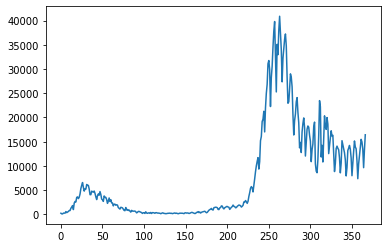

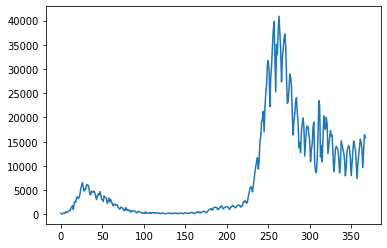

In [30]:
plt.plot(DPC_data.nuovi_positivi)
new_cases_expanded_no_trunc = draw_expanded_series(
    DPC_data.nuovi_positivi, draws=10, season_period=7, trend_alpha=ALPHA, difference_degree=2, 
    truncate=False,
    alpha=alpha, beta=beta)
plt.show()
plt.plot(new_cases_expanded_no_trunc[0,:])
new_cases_expanded_trunc = draw_expanded_series(
    new_cases_expanded_no_trunc[8,:], draws=10, season_period=7, trend_alpha=ALPHA, difference_degree=2, 
    truncate=True,
    alpha=alpha, beta=beta)
plt.show()


In [31]:
new_cases_expanded_second_degree = draw_expanded_series_double_degree(
    DPC_data.nuovi_positivi, draws=10, season_period=7, trend_alpha=100., difference_degree=2, 
    alpha=alpha, beta=beta    
)
new_cases_smoothed, padding_left = smooth_and_drop(
    new_cases_expanded_second_degree, season_period=7, trend_alpha=100., difference_degree=2)

rts_uncertain = []
for new_cases in new_cases_smoothed:
    rts_uncertain.append(Rt.naive.compute_Rt(
        np.nan_to_num(new_cases,nan=0.), alpha=alpha, beta=beta
    ))
rts_uncertain = np.array(rts_uncertain)

../covid19_pytoolbox/modeling/Rt/naive.py:25: RuntimeWarning: divide by zero encountered in true_divide
  return series / infectious_charge_
../covid19_pytoolbox/modeling/Rt/naive.py:25: RuntimeWarning: invalid value encountered in true_divide
  return series / infectious_charge_


In [32]:
interval = get_confidence_interval(new_cases_smoothed)
DPC_data['nuovi_positivi_smoothed_uncertain_CI_min'] = interval[0]
DPC_data['nuovi_positivi_smoothed_uncertain_CI_max'] = interval[1]

interval = get_confidence_interval(rts_uncertain)
DPC_data['nuovi_positivi_deseason_Rt_uncertain_CI_min'] = interval[0]
DPC_data['nuovi_positivi_deseason_Rt_uncertain_CI_max'] = interval[1]


/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1996: RuntimeWarning: invalid value encountered in greater
  cond0 = self._argcheck(*args) & (scale > 0) & (loc == loc)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:193: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


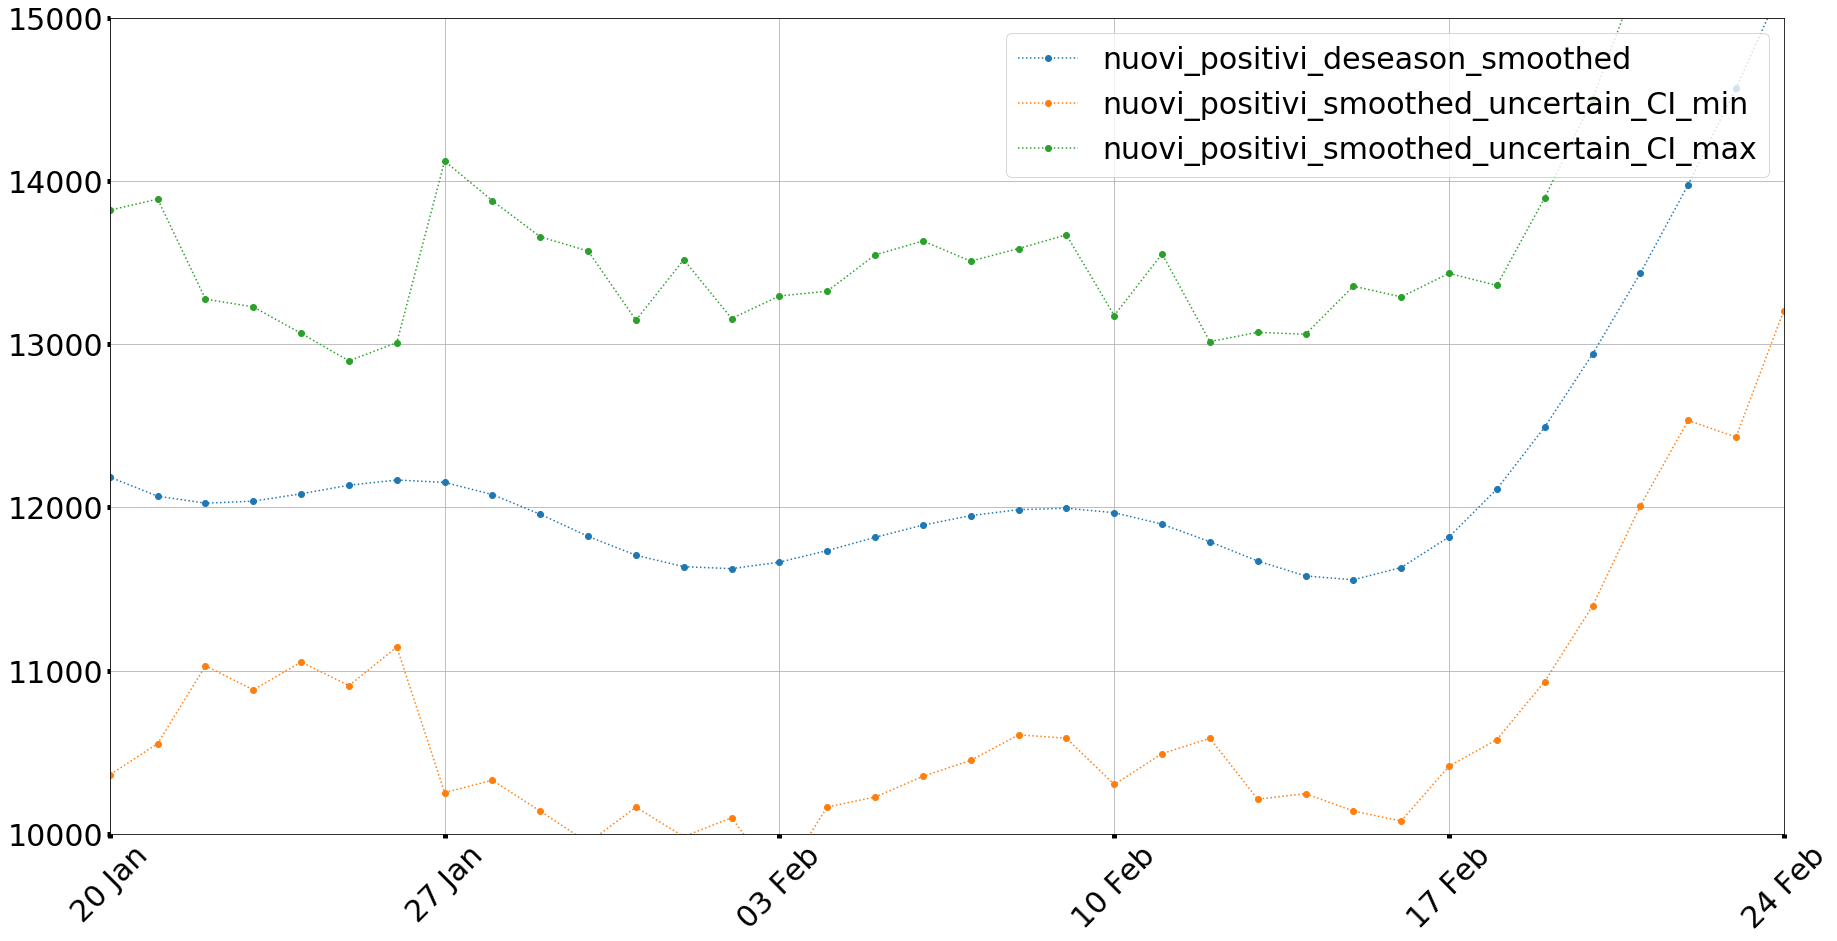

In [33]:
plotting.plot_series(
    df=DPC_data,
    yfields=[
        'nuovi_positivi_deseason_smoothed',
        'nuovi_positivi_smoothed_uncertain_CI_min',
        'nuovi_positivi_smoothed_uncertain_CI_max'
    ],
    xlim=(datetime(2021,1,20), DPC_data.data.max()),
    ylim=(10000,15000),
    legend_loc="upper right"
)

In [34]:
def wip_double_degree():
    PASTDAYS_BEGIN=100

    draws = 5
    res_window=2

    past_revisions=[]
    future_revisions=[]
    relative_residuals_sd=[]
    actual_residuals=[]
    try:
        for pastdays in range(PASTDAYS_BEGIN-1,0,-1):
            print(f'pastdays: {pastdays}')

            new_cases = DPC_data.nuovi_positivi.to_numpy()[:-pastdays]
            new_cases_expanded_second_degree = draw_expanded_series_double_degree(
                new_cases, draws=draws, season_period=7, trend_alpha=ALPHA, difference_degree=2, 
                alpha=alpha, beta=beta, res_window=res_window
            )
            new_cases_smoothed, padding_left = smooth_and_drop(
                new_cases_expanded_second_degree, season_period=7, trend_alpha=ALPHA,difference_degree=2)

            rts_uncertain = []
            for new_cases in new_cases_smoothed:
                rts_uncertain.append(Rt.naive.compute_Rt(
                    np.nan_to_num(new_cases,nan=0.), alpha=alpha, beta=beta
                ))
            rts_uncertain = np.array(rts_uncertain)
            interval = get_confidence_interval(rts_uncertain)
            DPC_data[f'nuovi_positivi_deseason_uncertain_Rt_CI95_min_{pastdays:02d}'] = padnan(
                interval[0], (0, pastdays)
            )
            DPC_data[f'nuovi_positivi_deseason_uncertain_Rt_CI95_max_{pastdays:02d}'] = padnan(
                interval[1], (0, pastdays)
            )



    except ValueError as ex:
        raise ex

In [35]:
def wip_plot_double_degree():
    for pastdays in range(PASTDAYS_BEGIN-1,0,-1):

        curdate = DPC_data.data.max()-timedelta(days=pastdays)
        plotting.plot_series(
            title='Rt: {00:%d} {0:%B} - pastdays: {1}'.format(curdate, pastdays),
            data=[
                {
                    'df': DPC_data,
                    'yfields': [
                        'nuovi_positivi_deseason_smoothed_Rt', 
                        f'nuovi_positivi_deseason_uncertain_Rt_CI95_min_{pastdays:02d}',
                        f'nuovi_positivi_deseason_uncertain_Rt_CI95_max_{pastdays:02d}'
                    ],
                    'labels': [
                        'Rt riferimento ad oggi',
                        f'Rt Tikhonov+Deseasoning alla data min',
                        f'Rt Tikhonov+Deseasoning alla data max',
                    ],
                    'colors':['gray', 'orange', 'orange']
                }
            ],
            xlim=(datetime(2020,11,11), DPC_data.data.max()),
            ylim=(0,1.3),
            legend_loc='lower right',
            #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,f'italy/archive/Rt_{curdate.isoformat()}'),
            #dpi=70,
            #quality=40
        )

In [36]:
np.warnings.filterwarnings('ignore')

PASTDAYS_BEGIN=2

draws = 10

past_revisions=[]
future_revisions=[]
relative_residuals_sd=[]
actual_residuals=[]
try:
    for pastdays in range(PASTDAYS_BEGIN-1,0,-1):
        print(f'pastdays: {pastdays}')
        
        new_cases = DPC_data.nuovi_positivi.to_numpy()[:-pastdays]
        new_cases_expanded = draw_expanded_series(
            new_cases, draws=draws, season_period=7, trend_alpha=ALPHA, difference_degree=2, 
            truncate=False,
            alpha=alpha, beta=beta    
        )
        new_cases_smoothed, padding_left = smooth_and_drop(
            new_cases_expanded, season_period=7, trend_alpha=ALPHA,difference_degree=2,
            noise=True, noise_size=30)

        rts_uncertain = []
        for new_cases in new_cases_smoothed:
            nn_new_cases = new_cases[~np.isnan(new_cases)]
            padding_left = len(new_cases) - len(nn_new_cases)
            rts_uncertain.append(padnan(Rt.naive.compute_Rt(nn_new_cases, alpha=alpha, beta=beta), (padding_left, 0), value=0.))
        rts_uncertain = np.array(rts_uncertain)
        interval = get_confidence_interval(rts_uncertain)
        rts_mean = np.mean(rts_uncertain, axis=0)

        DPC_data[f'nuovi_positivi_deseason_uncertain_2_Rt_CI95_min_{pastdays:02d}'] = padnan(
            interval[0], (0, pastdays)
        )
        DPC_data[f'nuovi_positivi_deseason_uncertain_2_Rt_CI95_max_{pastdays:02d}'] = padnan(
            interval[1], (0, pastdays)
        )
        DPC_data[f'nuovi_positivi_deseason_uncertain_2_Rt_mean_{pastdays:02d}'] = padnan(
            rts_mean, (0, pastdays)
        )
                        
        
except ValueError as ex:
    raise ex

pastdays: 1


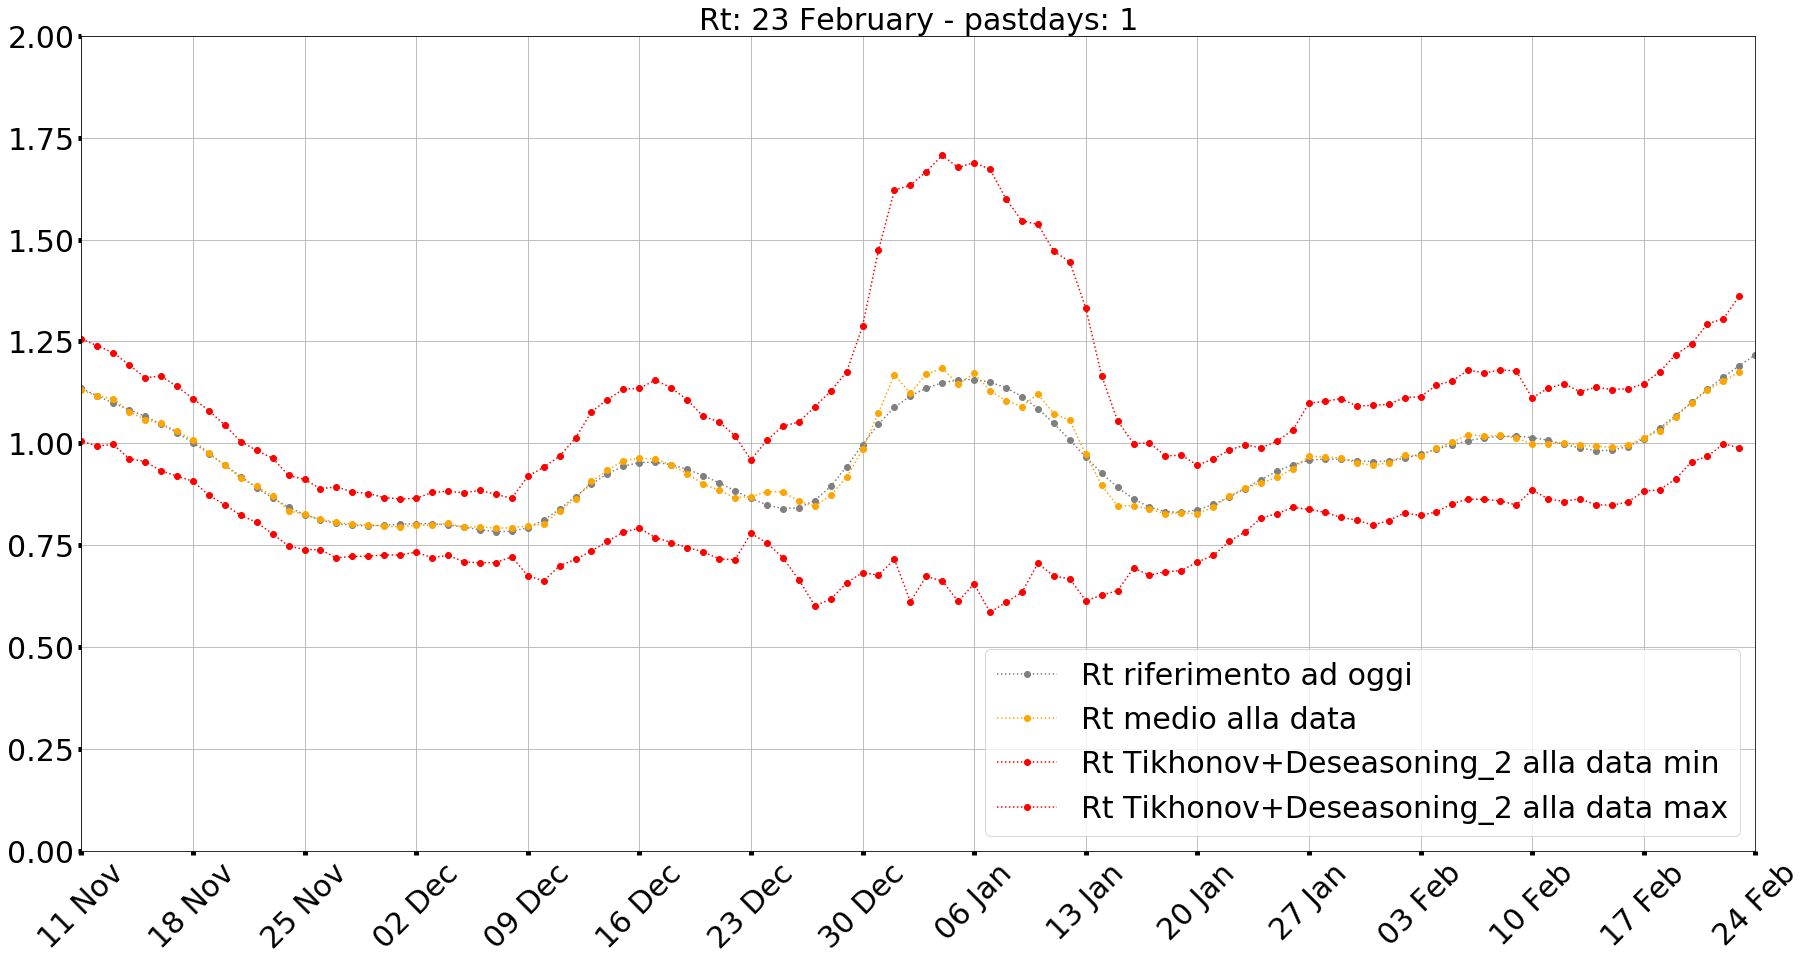

In [37]:
for pastdays in range(PASTDAYS_BEGIN-1,0,-1):

    curdate = DPC_data.data.max()-timedelta(days=pastdays)
    plotting.plot_series(
        title='Rt: {00:%d} {0:%B} - pastdays: {1}'.format(curdate, pastdays),
        data=[
            {
                'df': DPC_data,
                'yfields': [
                    'nuovi_positivi_deseason_smoothed_Rt', 
                    f'nuovi_positivi_deseason_uncertain_2_Rt_mean_{pastdays:02d}',
                    f'nuovi_positivi_deseason_uncertain_2_Rt_CI95_min_{pastdays:02d}',
                    f'nuovi_positivi_deseason_uncertain_2_Rt_CI95_max_{pastdays:02d}',
                ],
                'labels': [
                    'Rt riferimento ad oggi',
                    'Rt medio alla data',
                    f'Rt Tikhonov+Deseasoning_2 alla data min',
                    f'Rt Tikhonov+Deseasoning_2 alla data max',
                ],
                'colors':['gray', 'orange', 'red', 'red']
            }
        ],
        xlim=(datetime(2020,11,11), DPC_data.data.max()),
        ylim=(0,2),
        legend_loc='lower right',
        #img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,f'italy/archive/Rt_{curdate.isoformat()}'),
        #dpi=70,
        #quality=40
    )

In [24]:
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import theano


WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [36]:
def MCMC_sample(
    onset, 
    alpha, 
    beta, 
    rel_eps=None,
    eps_window=7,
    start=0, window=None, 
    chains=1, tune=4000, draws=4000, 
    target_accept=0.95, 
    dry=False, 
    cores=None,
    progressbar=True
):

    if not window:
        window = len(onset)
        
    if type(onset)==pd.DataFrame:
        onset = onset.values
        
    onset_ = onset[start:start+window]
    
    if not rel_eps is None:
        rel_eps_ = rel_eps[start:start+window]
        rel_eps_std = pd.Series(rel_eps_).rolling(window=eps_window).std().fillna(10.**(-3)).to_numpy()
        rel_eps_mean = pd.Series(rel_eps_).rolling(window=eps_window).mean().fillna(0.).to_numpy()
    
    steps = len(onset_)
    x = np.linspace(1,steps-1, steps)
    w = Rt.naive.gamma_df(x, alpha, beta)    
    
    with pm.Model() as model:
                
        # draws R_t from a prior normal distribution
        r_t = pm.Normal("r_t", mu=1.3, sigma=10., shape=len(onset_)-1)

        if not rel_eps is None:
            # sample noise from deseason epsilons and add it to the onsets
            rel_residuals = pm.Normal(
                name="rel_residuals", 
                mu=rel_eps_mean, 
                sigma=rel_eps_std,
                shape=len(rel_eps_std)
            )
            onset_residuals = pm.Deterministic(
                "onset_residuals", 
                onset_ + onset_ * rel_residuals
            )
        else:
            onset_residuals = onset_
        
        # compute the exptected number of current infectious 
        # based on the sampled R_t and the know past values of infectious
        #infectious_charge_ = Rt.naive.infectious_charge(onset_residuals, alpha, beta)[1:]
        
        infectious_charge_ = pm.Deterministic(
            "infectious_charge",
            tt.as_tensor([
                tt.sum(onset_residuals[t-1::-1]*w[:t]) 
                for t in range(1, steps)        
            ])            
        )         
        
        expected_today = r_t * infectious_charge_
        
        # Poisson requirements
        mu = pm.math.maximum(.1, expected_today)        
        observed = (onset_[1:]).round()

        # test the posterior: 
        # mu values derived from R_t samples 
        # must converge to the mean of real cases 
        # if they are Poisson distributed, as they are
        cases = pm.Poisson('cases', mu=mu, observed=observed)

        trace = None
        if not dry:
            trace = pm.sample(
                chains=chains,
                cores=cores,
                tune=tune,
                draws=draws,
                target_accept=target_accept,
                progressbar=progressbar)
        
            #assert not trace.diverging.any()
    
    return model, trace

In [37]:
def save_MCMC_sampling(df, column, trace, pastdays, interval=0.95, start=0):
    interval_frac = int(interval*100)
    sampling_mean = np.mean(trace['r_t'], axis=0)

    df[f'{column}_Rt_MCMC_pastdays_{pastdays:02d}'] = padnan(sampling_mean, (start,pastdays))
    

    #credible interval
    sampling_hdi = pm.stats.hpd(trace['r_t'], hdi_prob=interval)
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_min_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,0], (start,pastdays))
    df[f'{column}_Rt_MCMC_HDI_{interval_frac}_max_pastdays_{pastdays:02d}'] = padnan(
        sampling_hdi[:,1], (start,pastdays))


In [38]:
PASTDAYS_BEGIN=1

draws = 5
noise_size= 20

past_revisions=[]
future_revisions=[]
relative_residuals_sd=[]
actual_residuals=[]

for pastdays in range(PASTDAYS_BEGIN-1,-1,-1):
    print(f'pastdays: {pastdays}')

    if pastdays == 0:
        sl = np.s_[:]
    else:
        sl = np.s_[:-pastdays]
        
    new_cases = DPC_data.nuovi_positivi.to_numpy()[sl]
    
    new_cases_expanded, rel_eps = draw_expanded_series(
            new_cases, draws=draws, season_period=7, trend_alpha=ALPHA, difference_degree=2, 
            alpha=alpha, beta=beta, res_window=7, truncate=False
        )
    
    new_cases_smoothed, padding_left = smooth_and_drop(
        new_cases_expanded, season_period=7, trend_alpha=100.,difference_degree=2, 
    )#noise=True, noise_size=noise_size)

    print(rel_eps.shape)
    rel_eps = rel_eps[padding_left-1:]
    print(rel_eps.shape)    
    
    simulations = []
    for new_cases_s in new_cases_smoothed:
        print(new_cases_s[~np.isnan(new_cases_s)].shape)
        model_, trace_ = MCMC_sample(
            onset=new_cases_s[~np.isnan(new_cases_s)],
            alpha=alpha, beta=beta,
            rel_eps=rel_eps[:-1],
            start=0, window=None,
            chains=4,
            tune=500,
            draws=500,
            cores=4,
            dry=False,
            progressbar=False
        )
        simulations.append(trace_)

    sampled_Rt = np.array([t['r_t'] for t in simulations])
    combined_trace = {'r_t': sampled_Rt.reshape((-1,sampled_Rt.shape[2]))}

    save_MCMC_sampling(
        DPC_data, 'nuovi_positivi_smooth_deseas', combined_trace, pastdays, interval=0.95, start=padding_left+1)

    
    #DPC_data.to_pickle(os.path.join(BASE_DATA_PATH,'computed/WIP/deseason_MCMC_Rt.pickle'))

pastdays: 0
(368,)
(364,)
(363,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rel_residuals, r_t]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 609 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


(363,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rel_residuals, r_t]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 589 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


(363,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rel_residuals, r_t]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 640 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


(363,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rel_residuals, r_t]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 605 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


(363,)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [rel_residuals, r_t]
Sampling 4 chains for 500 tune and 500 draw iterations (2_000 + 2_000 draws total) took 590 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:487: FutureWarning: hdi currently interprets 2d data as (draw, shape) but this will change in a future release to (chain, draw) for coherence with other functions
  FutureWarning,


In [39]:
DPC_data.to_pickle(os.path.join(BASE_DATA_PATH,'computed/WIP/deseason_MCMC_Rt.pickle'))

In [ ]:
DPC_data[[
    'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_01', 
    'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_01',
    'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_01',
]]

In [ ]:
DPC_data[[
    'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_00', 
    'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_00',
    'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_00',
]]

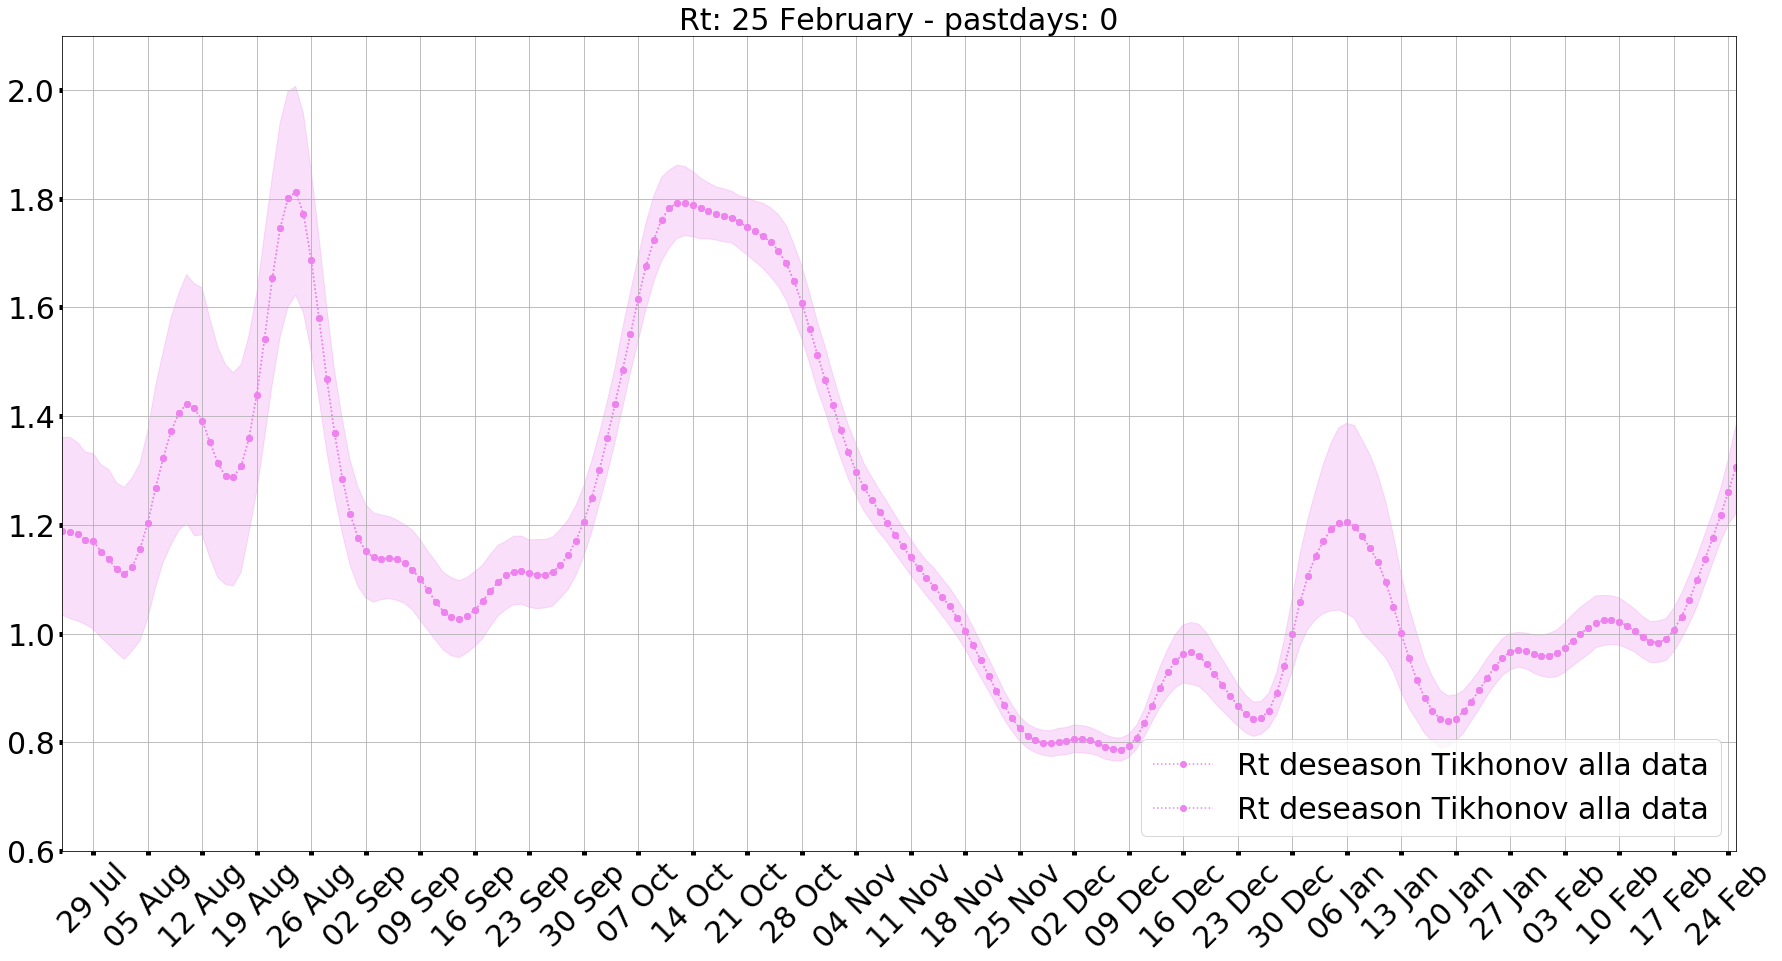

In [48]:
for pastdays in range(PASTDAYS_BEGIN-1,-1,-1):
#for pastdays in range(2-1,0,-1):

    curdate = DPC_data.data.max()-timedelta(days=pastdays)
    plotting.plot_series(
        title='Rt: {00:%d} {0:%B} - pastdays: {1}'.format(curdate, pastdays),
        data=[
            {
                'df': DPC_data,
                'xfield': 'data',
                'yfields': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_{pastdays:02d}', 
                    'nuovi_positivi_smooth_deseas_Rt_MCMC_pastdays_00'
                ],
                'fill_between': [
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_min_pastdays_{pastdays:02d}',
                    f'nuovi_positivi_smooth_deseas_Rt_MCMC_HDI_95_max_pastdays_{pastdays:02d}',
                ],
                'labels': [
                    f'Rt deseason Tikhonov alla data',
                    'Rt riferimento ad oggi'
                ],
                'colors':['violet', 'grey']
            },
        ],
        xlim=(datetime(2020,7,25), DPC_data.data.max()),
        ylim=(0.6,2.1),
        legend_loc='lower right',
        img_file_path_without_extension=os.path.join(BASE_IMAGES_PATH,f'italy/archive/Rt_{curdate.isoformat()}'),
        #dpi=70,
        #quality=40
    )